# «Модель прогнозирования стоимости жилья для агентства недвижимости»

### ПОСТАНОВКА ЗАДАЧИ

Агентство недвижимости столкнулось с проблемой — риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.

Типовая задача из области Data Science, основанная на данных о недвижимости в США.

**Бизнес-задача:** улучшить финансовые показатели компании за счет уменьшения времени на обработку информации о недвижимости у риелторов.

**Техническая задача для вас как для специалиста в Data Science:** разработать модель машинного обучения, которая поможет обрабатывать объявления и увеличит число сделок и прибыль агентства.

**Основные цели проекта:**
1. Провести разведывательный анализ и очистку исходных данных.
2. Выделить наиболее значимые факторы, влияющие на стоимость недвижимости.
3. Построить модель для прогнозирования стоимости недвижимости.
4. Разработать небольшой веб-сервис, на вход которому поступают данные о некоторой выставленной на продажу недвижимости, а сервис прогнозирует его стоимость.

Десериализацию выполнила в отдельном ноутбуке.

In [1083]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np

np.set_printoptions(suppress=True) # для вывода значений не в экспоненциальном виде

from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

На предыдущем этапе была произведена десериализация признаков.

Рассмотрим внимательно данные, с которыми нам предстоит работать, и произведем базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.

In [1084]:
#прочитаем данные из файла
realty = pd.read_csv('full_data.csv', sep = ',') 

In [1085]:
#проверим, что данные выгрузились корректно, для этого выведем первые две строки датафрейма
display('Таблица данных недвижимости',realty.head(2))

'Таблица данных недвижимости'

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,MlsId,target,yearBuilt,remodeledYear,heating,cooling,parking,price_sqft,sch_rating,sch_dist
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,...,611019,"$418,000",2019,NaN,"Central A/C, Heat Pump",NaN,NaN,NaN,"['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5..."
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",...,201916904,"$310,000",2019,NaN,NaN,NaN,NaN,5828 sqft,"['4/10', 'None/10', '4/10']","['1.65mi', '1.32mi', '1.01mi']"


Итак, в нашем распоряжении более чем 300 тыс. наблюдений и 26 признаков:

* 'propertyType' — тип объекта недвижимости;
* 'street' — адрес объекта;
* 'baths' — количество ванных комнат;
* 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
* 'yearBuilt' - год постройки недвижимости;
* 'remodeledYear' - год реконструкции недвижимости;
* 'heating' - информация об отоплении;
* 'cooling'- информация о системе охлаждения;
* 'parking' - информация о парковке; 
* 'price_sqft' - цена одного квадратного фута;
* 'fireplace' — наличие камина;
* 'city' — город;
* 'schools' — сведения о школах в районе;
* 'sch_rating' - рейтинг школ;
* 'sch_dist' - дистанция до школ;
* 'sqft' — площадь в футах;
* 'zipcode' — почтовый индекс;
* 'beds' — количество спален;
* 'state' — штат;
* 'stories' — количество этажей;
* 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);
* 'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

На предыдущем этапе было выяснено, что в данных есть пропуски. Приступим к этапу обработки и очистки данных.

### ОБРАБОТКА И ОЧИСТКА ДАННЫХ

На этом этапе подготовим наш датасет для дальнейшего моделирования, произведя предобработку и очистку данных. Обработку признаков будем производить в соответствии с их расположением в талбице.

In [1086]:
#посмотрим на доли пропусков в призаках, в которых они есть
cols_null_percent = realty.isnull().mean() * 100 #находим долю пропусков в каждом столбце таблицы
#выделяем столбцы с пропусками
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
#выведем столбцы с пропусками
display('Таблица соостветствия признака и пропущенных в нем значений',cols_with_null)

'Таблица соостветствия признака и пропущенных в нем значений'

private pool     98.891525
mls-id           93.387330
PrivatePool      89.312672
fireplace        72.662221
remodeledYear    59.946711
parking          47.134960
stories          39.958111
cooling          34.825616
heating          29.005395
baths            28.192532
beds             24.200856
MlsId            17.731352
yearBuilt        16.536713
price_sqft       16.293066
sqft             10.757851
status           10.583136
propertyType      9.208479
target            0.657767
city              0.009014
street            0.000530
dtype: float64

Видим, что у нас есть два признака, значения которого распределены по двум столбцам: признак наличия бассейна(private pool и PrivatePool) и признак, содержащий идентификатор объекта недвижимости в мультистиллинговой системе (mls-id и MlsId). Данные в этих признаках неполные, в них содержится максимальное число пропусков.

Считаю признак идентификатор объекта недвижимости в мультистиллинговой системе малоинформативнымм, так как он содержит много уникальных значений и поэтому не поможет в построении модели. Ввиду этого обстоятельства, полагаю - его можно удалить.

На число пропусков в признаке наличия бассейна попробуем посмотреть после объединения столбцов. 

Признак наличия камина ('fireplace') содержит 73 % пропусков, удалим этот признак.

Большое число пропусков содержит признак количества этажей 'stories'. Рассмотрим его поближе и решим, что с ним делать.

Признак street имеет много уникальных значений, поэтому не является информативным, не будем использовать его для построения модели, но используем его для очистки и заполнения недостающих данных, а потом удалим.

Проверим есть ли в нашей таблице неинформативные строки. Для этого построим диаграмму.

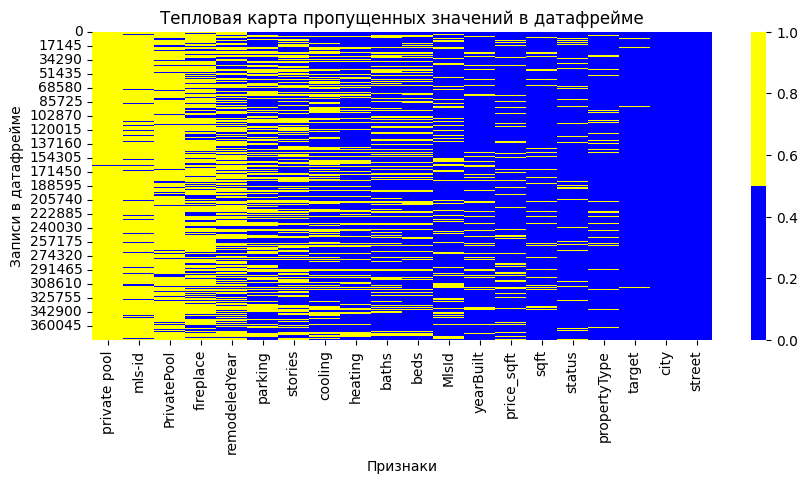

In [1087]:
colors = ['blue', 'yellow'] #задаем цвета для диаграммы

fig = plt.figure(figsize=(10, 4)) #задаем размер полотна диаграммы

cols = cols_with_null.index #выделяем индексы пропущенных значений
fig_str_null = sns.heatmap(
    realty[cols].isnull(),
    cmap=sns.color_palette(colors),
);
fig_str_null.set_title('Тепловая карта пропущенных значений в датафрейме');
fig_str_null.set_xlabel('Признаки');
fig_str_null.set_ylabel('Записи в датафрейме');

По диаграмме видно, что есть строки с большим числом пропусков, если мы будем восстанавливать больше 50 % данных в строке, то это ухудшит качество нашей модели. Пропуски в строках тоже надо будет удалить.

In [1088]:
num_dublicat = len(realty[realty.duplicated()])
display(f'Число дубликатов в таблице равно {num_dublicat}.')

'Число дубликатов в таблице равно 50.'

Итак, удалим:
* столбцы с признаками msl-id  и MlsId
* десериализованные столбцы с homeFacts и schools
* столбец с признаков fireplace
* строки, содержащие большое число пропущенных значений (возьмем число заполненных значений равным 70%)
* дубликаты

In [1089]:
# удаляем неинформативные признаки
realty.drop(['mls-id', 'MlsId', 'fireplace'], axis=1, inplace=True) 
realty.drop(['homeFacts', 'schools'], axis=1, inplace=True)
# удаляем полные дубликаты
realty.drop_duplicates(inplace=True) 

#удаляем неинформативные наблюдения
trash = realty.shape[1]*0.5#определяем число непустых значений в строке
#удаляем строки, содержащией меньше 50 % непустых знаячений
realty = realty.dropna(thresh = trash, axis=0)

print('Размерность таблицы после удаления пропусков и дубликатов:{0}'.format(realty.shape))

Размерность таблицы после удаления пропусков и дубликатов:(348512, 21)


Дальнейшую обработку пропусков продолжим, обрабатывая каждый признак в отдельности. 

### Обработка признака - статус продаж (status)

In [1090]:
display('Число пропусков в признаке status: {:.3f} %'.format(realty['status'].isnull().mean()*100))
display('Число уникальных значений в признаке status: {:.0f}'.format(realty['status'].nunique()))
display('Доля строк заполненных каждым уникальным значением признака status: ',\
    realty['status'].value_counts()/realty.shape[0])

'Число пропусков в признаке status: 10.565 %'

'Число уникальных значений в признаке status: 159'

'Доля строк заполненных каждым уникальным значением признака status: '

status
for sale                0.414273
Active                  0.263228
For sale                0.124664
foreclosure             0.018054
New construction        0.015687
                          ...   
Coming soon: Oct 24.    0.000003
Pending Sale            0.000003
Coming soon: Oct 21.    0.000003
Coming soon: Nov 14.    0.000003
Coming soon: Dec 23.    0.000003
Name: count, Length: 159, dtype: float64

Рассмотрим внимательнее данный признак.

Мы видим,что большая часть данных представлена следующими типами собственности: for sale, active,foreclosure, new construction, pending - поэтому считаю возможным выделить означенные типы основными, а для остальных создать признак other.

Однако среди уникальных признаков обнаружили признаки, которые несут одинаковую информацию.

Итак выделим основные типы:
* тип 'active' к нему будем относить 'for sale', 'activated', а также типы содержащие 'active'
* тип 'foreclosure' (тип будет включать нетрадиционные продажи): 'foreclosed' («лишён права выкупа»), все типы содержащие 'auction'
* тип 'pending' включает все варианты, в которых оформление сделки началось, но по каким-то причинам остановилось, а также тип 'contingency' предполагающий дополнительные обстоятельства и всего его варианты
* тип 'new': это недвижимость обозначенная типом 'new', 'new construction' и типы содержащие конструкцию 'coming soon: <date>'
* тип 'other' будет включать все типы не вошедшие в предыдущие варианты, в том числе отсутствующие значения.

Анализируя, уникальные типы обнаружили тип недвижимости 'apartment for rent', возможно имеются и другие варианты подразумевающие арендуемую недвижимость. Сначала выделим в отдельный тип недвижимости все подобные записи и удалим их, так как стоимость, наш целевой признак, арендуемого имущества указывается за месяц и поэтому не поможет нам в построении модели.

In [1091]:
# напишем функцию для объединения похожих по сути признаков
def fill_same(df, feature, same_dict):
    ''' На вход функция получает датафрейм, признак, в котором будет производиться объединение и 
    словарь со списками похожих по сути значениями.
    
    Функция будет возвращать обновленный столбец исходного датафрейма с объединенными по смыслу признаками.
    '''
    df[feature]=df[feature].str.lower() #приводим значения к нижнему регистру
    for i in same_dict.keys(): # проходимся циклом по всем ключам i словаря
        for j in same_dict[i]: # проходимся циклом по всем значениям j списка с ключом i словаря
            # применяем к каждому значению функцию lambda, которая проверяет на схожесть значения
            # со значением из списка
            df[feature]= df[feature].apply(lambda x: i if str(x).__contains__(j)==True else x)
    return df[feature]# возвращаем обновленную колонку датафрейма  
                              

Прежде проверим, какие значения в признаке статуса недвижимости содержат ключевое слово rent, которое мы будем использовать в дальнейшем для отнесения объекта к группе арендуемого имущества. Для этого напишем функцию, которая будет выдавать список уникальных значений признака, содержащих ключевые слова.

In [1092]:
def search_key(df,feature,key_lst):
    '''Функция на вход получает датафрейм, признак, в значениях которого будем искать ключевое слово,
    и список ключевых слов.
    
    Функция возвращает список уникальных значений признака.
    '''
    df[feature] = df[feature].str.lower()# приводим значение признака в ячеке датафрейма к нижнему регистру
    lst=[]#создаем пустой список, который будем заполнять
    for i in key_lst: #проходим по списку искомых значений циклом
        for j in df.index:#проходим по индексам датафрейма циклом
            if str(df.loc[j,feature]).__contains__(i)== True: #если строка содержит один из ключей списка key_lst
                lst.append(df.loc[j,feature])#добавляем значение в список
            else: #если строка не содержит ни один из ключей
                lst#возвращаем тот же список
    return set(lst) #возвращаем список уникальных значений признака, содержащих одно из ключевых слов

In [1093]:
# определим словарь, который будет содержать информацию о том, что включает в себя каждый тип
type_dict = {'foreclosure': ['auction', 'foreclo'], # типы, относящиеся к foreclosure
    'pending': ['pend', 'conting'], # типы, относящиеся к pending
    'new': ['coming', 'new'], # типы, относящиеся к new
    'active': ['for sale', 'activated', 'active', 'back on market'],# типы, относящиеся к active
    'rent': ['rent']} # типы, относящиеся к rent

In [1094]:
#определим список ключевых значений
rent_lst = ['rent']

display('Уникальные значения признака - статус продажи, содержащие ключевое слово "rent":',\
    search_key(realty,'status',rent_lst))

'Уникальные значения признака - статус продажи, содержащие ключевое слово "rent":'

{'apartment for rent', 'condo for rent', 'for rent'}

Видим, что полученный список включает только объекты статус которых подтверждает, что это недвижимость в аренду. Поэтому после выделения группы rent, можем ее смело удалять.

In [1095]:
# применим функцию fill_type_feature к признаку - статус продажи
realty['status'] = fill_same(realty,'status',type_dict)

# выделим тип недвижимости other  
realty['status']=realty['status'].apply(lambda x: x if x in list(type_dict.keys()) else 'other')

# удалим из таблицы строки, содержащие данные об объектах недвижимости, которые сдаются в аренду
index_rent = realty[realty['status']=='rent'].index 
realty.drop(index_rent, axis = 0, inplace = True)

display('Число пропусков в признаке status: {:.3f} %'.format(realty['status'].isnull().mean()*100))
display('Число уникальных значений в признаке status: {:.0f}'.format(realty['status'].nunique()))
display('Доля строк заполненных каждым уникальным значением признака status: ',\
    realty['status'].value_counts()/realty.shape[0])

#выведем размерность таблицы
print('Размерность таблицы после удаления rent:{0}'.format(realty.shape))

'Число пропусков в признаке status: 0.000 %'

'Число уникальных значений в признаке status: 5'

'Доля строк заполненных каждым уникальным значением признака status: '

status
active         0.807078
other          0.121709
foreclosure    0.034861
pending        0.018391
new            0.017960
Name: count, dtype: float64

Размерность таблицы после удаления rent:(348100, 21)


### Обработка признака PrivatePool

Объединим столбцы 'private pool' и 'PrivatePool' и посмотрим на число пропусков после объединения.

In [1096]:
# объединим столбцы, для нового столбца сохраним название PrivatePool
realty['PrivatePool'] = realty[['PrivatePool', 'private pool']].bfill(axis =1).iloc[:,0]

# проверим число пропусков
display('Число пропусков в столбце с признаком наличие бассейна после объединения столбцов {0} %'.\
    format(round(realty['PrivatePool'].isnull().mean()*100,2)))

'Число пропусков в столбце с признаком наличие бассейна после объединения столбцов 87.25 %'

Улучшить положение за счет объединенния признака в один столбец не получилось, данные содержат 85.23 % пропущенные значений, являются для нас неинформатиными, поэтому мы удалим эти столбцы из таблицы.

In [1097]:
# Удаляем эти неинформативные признаки
realty.drop(['private pool', 'PrivatePool'], axis=1, inplace=True)

print('Размерность таблицы:{0}'.format(realty.shape))

Размерность таблицы:(348100, 19)


In [1098]:
#для продолжения обработки копируем таблицу
r1 = realty.copy()

### Обработка признака - тип объекта недвижимости ('propertyType') 

In [1099]:
display('Число пропусков в признаке propertyType: {:.3f} %'.format(r1['propertyType'].isnull().mean()*100))
display('Число пропусков в признаке propertyType: {:.0f}'.format(r1['propertyType'].isnull().sum()))
display('Доля строк заполненных каждым уникальным значением признака status: ',\
    r1['propertyType'].value_counts()/realty.shape[0])

'Число пропусков в признаке propertyType: 5.290 %'

'Число пропусков в признаке propertyType: 18414'

'Доля строк заполненных каждым уникальным значением признака status: '

propertyType
single-family home                                             0.263528
Single Family                                                  0.180388
Single Family Home                                             0.091040
condo                                                          0.074444
Condo                                                          0.047538
                                                                 ...   
Custom, Elevated, Other                                        0.000003
1 Story, Contemporary, Other (See Remarks)                     0.000003
2 Stories, Traditional, Mediterranean, Texas Hill Country      0.000003
Contemporary, Farmhouse                                        0.000003
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit    0.000003
Name: count, Length: 1276, dtype: float64

In [1100]:
#для упрощения дальнейшей обработки приведем значения в ячейках признака propertyType к нижнему регистру
r1['propertyType'] = r1['propertyType'].str.lower()

Во время исследования значений признака были обнаружены ячейки, содержащие информацию для признака stories.

In [1101]:
#определим список ключевых значений
#stor_from_type = ['stor']

#display('Количество ячеек в признаке propertyType, содержащих информацию о признаке stories: {0}'\
    #.format(len(search_key(r1,'propertyType',stor_from_type))))

Во время анализа значений признака были выявлены наблюдения, в которых в признаке propertyType содержалась информация о количестве этажей. Заменим пустые ячейки в признаке stories заполненными ячейками из propertytype.

In [1102]:
#в отдельную таблицу соохраняем значения признака propertyType, содержащие stories
stor_from_property = r1[r1['propertyType'].str.contains('stor',case=False) == True]
#находим в таблице stor_from_property наблюдения propertyType соответствующие пустым ячейкая в stories
stor_ind = stor_from_property[stor_from_property['stories'].isnull()==True].index
display('Число пропусков в признаке stories до добавления информации из propertyType:{0}'\
    .format(r1['stories'].isnull().sum()))
#заменяем пустые значения из stories значениями из propertyType
r1.loc[stor_ind,'stories'] = r1.loc[stor_ind,'propertyType']
display('Число пропусков в признаке stories после добавления информации из propertyType:{0}'\
    .format(r1['stories'].isnull().sum()))

'Число пропусков в признаке stories до добавления информации из propertyType:121658'

'Число пропусков в признаке stories после добавления информации из propertyType:113987'

Признак содержит значения, которые обозначены разными выражениями, но имеют одинаковую суть, для обработки применим функцию fill_type_feature, написанную ранее. 

Отдельно выделим:
* single - отдельно стоящие дома для одной семьи;
* apartment - квартиры;
* condo - квартиры в кондоминимумах;
* mobile - мобильные дома,
* townhouse - недвижимость в таунхаусах;
* multi - дома на несколько семей;
* land - участки земли,
* cabin - небольшие загородные домики,
* other - другие типы не вошедшие в вышеперечисленные.

Оформим словарь ключом, которого станет название объединяющего типа, а список значений составят выражения, которые либо имеют тот же смысл, либо являются описательными характеристиками типа.

По итогам удалим объекты с типом land, так как этот тип не является жилым, по условию задачи необходимо построить модель прогнозирования стоимости жилой недвидимости. Но сначала, проверим, какие данные содержат ключевое слово land.

In [1103]:
#определим список ключевых значений
land_lst = ['land']

display('Уникальные значения признака - статус продажи, содержащие ключевое слово "land":',\
    search_key(r1,'propertyType',land_lst))

'Уникальные значения признака - статус продажи, содержащие ключевое слово "land":'

{'contemporary, new englander',
 'double-wide mobile with land',
 'land',
 'lot/land',
 'multi-level, new englander',
 'new englander',
 'single detached, single-wide mobile with land',
 'single-wide mobile with land',
 'single-wide mobile with land, traditional'}

Видим, что, выбирая в качестве ключевого слова land, мы можем потерять данные, которые скорее относятся к типу недвижимости single. 

Вручную заменим найденные значения на соответствующие типы, а затем применим функцию fill_type_feature.

In [1104]:
#заменим вручную содержащие ключевое слово land строки
r1['propertyType']=r1['propertyType'].str.lower().replace('contemporary, new englander','single')
r1['propertyType']=r1['propertyType'].str.lower().replace('new englander','single')
r1['propertyType']=r1['propertyType'].str.lower().replace('multi-level, new englander','multi')
r1['propertyType']=r1['propertyType'].str.lower()\
    .replace('double-wide mobile with land','mobile')
r1['propertyType']=r1['propertyType'].str.lower()\
    .replace('single detached, single-wide mobile with land','mobile')
r1['propertyType']=r1['propertyType'].str.lower()\
    .replace('single-wide mobile with land, traditional','mobile')
r1['propertyType']=r1['propertyType'].str.lower()\
    .replace('single-wide mobile with land','mobile')

In [1105]:
#создадим словарь схожих значений признака
prop_dict = {'townhouse':['townhouse','townhome','row','patio'],
             'apartment':['apartment','high rise','penthouse','high-rise','mid-rise','loft','mid rise',\
                 'hi-rise','unit','co-op','coop'],
             'condo':['condo'],
             'mobile':['mobile','manufact', 'prefab', 'modular','mo2 le', 'mo2le','cluster home'],
             'single':['single','1 story','2 story','detached', 'tiny home','cape cod','farmhouse','ranch',
                 'two stor','low-rise','cottage','one story','log home','farm house','cape','a-frame',
                     'bungalow','charleston','english','low rise','elevated','tradit','old','histor','tudor',
                     'craftsman', 'contemporary','greek revival','french country','mediterranean',
                 'midcentury modern','victorian','colonial','french','modern','prairie','courtyard'],
             'multi':['multi','duplex', 'triplex', 'fourplex','4-plex'],
             'land':['land'],
             'other':['other','unknown','miscellaneous','yes'],
             'cabin':['cabin','ca2 n','ca2n','lake','coastal','garden','camp']
             }

#скопируем столбец с признаком - тип недвижимости
r1['type'] = r1['propertyType']
#обрабатываем столбец с признаком 'propertyType' с помощью функции fill_type_feature
r1['type'] = fill_same(r1, 'type', prop_dict)
#заполняем пропущенные значения модой по признаку типа недвижимости
type_null_ind = r1[r1['type'].isnull()==True].index
r1.loc[type_null_ind,'type']='single'

#относим значения не отнесенные ни к одному типу, означенному в словаре к 'single'
r1['type']=r1['type'].\
    apply(lambda x: x if x in list(prop_dict.keys()) else 'other')

In [1106]:
#проверим, какие наблюдения были отнесены к типу land
type_land = r1[r1['type']=='land']
#выделим идексы строк, в которых значения признаков baths и bads ненулевые
not_land_ind = type_land[(type_land['baths'].isnull()==False)|(type_land['beds'].isnull()==False)\
    |(type_land['stories'].isnull()==False)].index
#заменим в выделенных значениях тип land на тип not_land
r1.loc[not_land_ind,'type']='not_land'

In [1107]:
# удалим из таблицы строки, содержащие данные о земельных участках
index_land = r1[r1['type']=='land'].index 
r1.drop(index_land, axis = 0, inplace = True)

In [1108]:
display('Число пропусков в признаке propertyType: {:.3f} %'.format(r1['type'].isnull().mean()*100))
display('Число пропусков в признаке propertyType: {:.0f}'.format(r1['type'].isnull().sum()))
display('Доля строк заполненных каждым уникальным значением признака propertyType: ',\
    r1['type'].value_counts()/realty.shape[0])
print('Размерность таблицы:{0}'.format(r1.shape))

'Число пропусков в признаке propertyType: 0.000 %'

'Число пропусков в признаке propertyType: 0'

'Доля строк заполненных каждым уникальным значением признака propertyType: '

type
single       0.662574
condo        0.122945
townhouse    0.077848
multi        0.035688
not_land     0.022292
apartment    0.020204
other        0.011968
mobile       0.010738
cabin        0.001003
Name: count, dtype: float64

Размерность таблицы:(336007, 20)


In [1109]:
#перед обработкой признака числа этажей 
r2=r1.copy()

### Обработка признака количества этажей ('stories')

In [1110]:
display('Число пропусков в признаке stories: {:.3f} %'.format(r2['stories'].isnull().mean()*100))
display('Число пропусков в признаке stories: {:.0f}'.format(r2['stories'].isnull().sum()))
display('Доля строк заполненных каждым уникальным значением признака stories: ',\
    r2['stories'].value_counts()/r2.shape[0])


'Число пропусков в признаке stories: 30.325 %'

'Число пропусков в признаке stories: 101894'

'Доля строк заполненных каждым уникальным значением признака stories: '

stories
1.0                                                                               0.200734
2.0                                                                               0.164523
1                                                                                 0.068692
2                                                                                 0.053999
3.0                                                                               0.033547
                                                                                    ...   
2 stories, traditional, other (see remarks)                                       0.000003
Sixplex                                                                           0.000003
3+ stories, texas hill country                                                    0.000003
historical/conservation district, single detached, early american, traditional    0.000003
65.0                                                                              

Этот признак содержит, на мой взгляд, разные данные, есть информация об этажах в целом зданий (число этажей в доме, например), есть этаж, на котором находится квартира, есть число уровней в апартаментах. Я использую этот признак для разделения большой группы домов по этажам, а затем удалю признак из таблицы.

In [1111]:
#для удобства обработки приведем значения в строке к нижнему регистру
r2['stories']=r2['stories'].str.lower()

Посмотрим на уникальные значения признака, которые содержат слово этаж.

In [1112]:
#определим список ключевых значений
#stor_lst = ['stor']

#display('Уникальные значения признака - статус продажи, содержащие ключевое слово stor:',\
    #search_key(r2,'stories',stor_lst))

In [1113]:
#создадим словарь значений на замену
stor_dict = {'1.5':['1 1/2 story','1.5 story','1.5 stories'],
          '1.0':['one','1 story'],
          '2.0':['two story','2 story','2 stories'],
          '3.0':['three']}
#заменим слова 
r2['stories'] = fill_same(r2,'stories',stor_dict)

In [1114]:
#заменим '0','0.0','~' на значения nan
r2['stories']=r2['stories'].replace('0',np.nan)
r2['stories']=r2['stories'].replace('0.0',np.nan)
r2['stories']=r2['stories'].replace('~',np.nan)

In [1115]:
display('Число пропусков в признаке stories: {:.3f} %'.format(r2['stories'].isnull().mean()*100))

'Число пропусков в признаке stories: 33.752 %'

Приведем значения признака к числовому типу, для этого напишем преобразующую функцию.

In [1116]:
# импортируем модуль для построения регулярных выражений
import re

# напишем функцию для обработки признака
def fill_numeric(number):
    '''Функция на входе принимает значение признака, преобразует его в строковое значение,
    выделяет количество признака в формате float, так как значение может быть дробным.
    
    Возвращает функция либо значение float, либо nan, если значение было пустым или
    не соответствовало описанному регулярному выражению.
    '''
    if number is np.nan: #проверяем является ли строка пустой
        return np.nan #возвращаем nan, если строка пустая
    else: #если строка непустая
        #находим все числа удовлетворяющие регулярному выражению и собираем в список
        result = re.findall(r'\d+\.*,*\d*',str(number)) 
        if result!=[]:#если список значений непустой
            result = result[0] #берем первое значение списка найденных значений
            result = float(result.replace(',','.')) #преобразуем его к типу float
            return result #возвращаем число
        else:# если в строке не найдено чисел 
            return np.nan #возвращаем nan   

In [1117]:
#применим фукцию для преобразования признака - число этажей
r2['stories']=r2['stories'].apply(lambda x: fill_numeric(x))

In [1118]:
display('Число пропусков в признаке stories: {:.3f} %'.format(r2['stories'].isnull().mean()*100))

'Число пропусков в признаке stories: 35.221 %'

Видим, что после предварительной обработки число пропусков увеличилось.

In [1119]:
display('Число пропусков в признаке stories по типу недвижимости single: {:.3f} %'\
    .format(len(r2[(r2['stories'].isnull()==True)&(r2['type']=='single')])/r2.shape[0]*100))

'Число пропусков в признаке stories по типу недвижимости single: 20.686 %'

Среди объектов типа недвидимости single число пропусков не такое большое, поэтому можем его заполнить для дальнейшей обработки single.

Заполним пропуски в признаке stories во всем датасете, а использовать будем только часть заполненную для single.

Поскольку stories числовой признак, то пропуски заполним медианным значением по типу недвижимости, так как медиана не зависит от выбросов.

In [1120]:
#напишем функцию для заполнения пустых значений медианным значением по типу недвижимости
def fill_null(df,f1,f2,lst):
    '''Функция принимает на вход:
    - df - датафрейм, 
    - f1 - признак, который необходимо обработать,
    - f2 - признак, по которому происходит группировка для поиска медианы,
    - lst - список групп
    
    Функция возвращает обработанный столбец признака f1
    '''
    for i in lst: #проходимся в цикле по всем типу недвижимости, по которым находим медиану
        df_f2 = df[df[f2]==i][f1] #фильтруем df по признаку f2 и выводим значения f1
        null_ind = df_f2[df_f2.isnull()==True].index #находим индексы для пустых значений признака f1
        if len(df[df[f2]==i][f2])==len(df_f2[df_f2.isnull()==True].index):
            df.loc[null_ind,f1] = df[f1].median()          
        else:
            df.loc[null_ind,f1] = df[df[f2]==i][f1].median() #заполняем пустые значения признака f1 медианой         
    return df[f1]

In [1121]:
#зададим список типов недвижимости для расчета медианы
type_list = ['single','apartment','condo','mobile','townhouse','multi','traditional',
             'style_house','not_land', 'cabin','other']

In [1122]:
#заполним пропуски в признаке stories медианными значениями, группируя по типу недвижимости type
r2['stories'] = fill_null(r2,'stories','type',type_list)

### Дообработка признака type

In [1123]:
#для дальнейшей обработки выделим в отдельную таблицу наблюдения с типом недвижимости single
table_single = r2[r2['type']=='single']

In [1124]:
#table_single[(table_single['stories']>=5)|(table_single['stories']==1.3)|(table_single['stories']==1.2)\
    #|(table_single['stories']==2.2)|(table_single['stories']==3.5)|(table_single['stories']==1.7)]\
        #[['beds','propertyType','baths','sqft','stories']].sort_values('stories')[:25]

Дома с числом этажей больше 5 вызывают вопросы, таких записей 141 шт. Скорее всего это неверные данные. Заполним их медианными значениями по типу недвижимости. Сохраним наблюдения с числом этажей 1.2, 1.3, 2.2,1.7 и 3.5, округлив до целого.

In [1125]:
# округлим данные
r2['stories'] = r2['stories'].replace(1.2,1)
r2['stories'] = r2['stories'].replace(1.3,1)
r2['stories'] = r2['stories'].replace(1.7,2)
r2['stories'] = r2['stories'].replace(2.2,2)
r2['stories'] = r2['stories'].replace(3.5,4)

In [1126]:
#выделим наблюдения в таблице table_single, в которых stories >5
ind_for_change = table_single[table_single['stories']>=5].index
#заменим выделенные значения на медианные значения по группе single
r2.loc[ind_for_change,'stories']=table_single['stories'].median()

Выделим новые типы домов недвижимости типа single с учетов числа этажей. Для этого напишем функцию.

In [1127]:
#функция изменения типа недвижимости в зависимости от числа этажей
def change_type(df, x, s):
    '''Функция на вход получает датафрейм, x - признак, который подлежит изменению,
    s - признак, по которому будем менять признак x.
    
     Функция возвращает обновленный признак x в датафреме.
    '''
    for i in df.index: #проходимся по всем индексам датафрема в цикле
        if df.loc[i,x]!='single': #если значение признака соответствует single
            df.loc[i,x] = df.loc[i,x] # то, ячейка сохраняет свое значение
        else: # если условие не выполняется
            if df.loc[i,s]==1: #если число этажей равно 1
                df.loc[i,x]='single_1' #то, значение в ячейке равно single_1
            elif (df.loc[i,s]>1) and (df.loc[i,s]<=2):#если число этажей от 1 до 2
                df.loc[i,x]='single_2'#то, значение в ячейке равно single_2
            elif (df.loc[i,s]>2) and (df.loc[i,s]<=3):#если число этажей от 2 до 3
                df.loc[i,x]='single_3'#то, значение в ячейке равно single_3
            elif df.loc[i,s]==4:#если число этажей равно 4
                df.loc[i,x]='single_4'#то, значение в ячейке равно single_4
    return df[x] #возвращаем обновленный столбец датафрейма

In [1128]:
#применим функцию change_type к признаку type
r2['type']=change_type(r2,'type','stories')

In [1129]:
#удалим столбец stories
r2.drop(['stories'], axis=1, inplace=True)

print('Размерность таблицы:{0}'.format(r2.shape))

Размерность таблицы:(336007, 19)


In [1130]:
#сохраним таблицу для дальнейшей обработки
r3=r2.copy()

### Обработка признака количества ванных комнат (baths)

Проанализируем признак количества ванных комнат (baths). Посмотрим на уникальные значения признака, чтобы понять как преобразовать данные.

In [1131]:
display('Число пропусков в признаке baths: {:.3f} %'.format(r3['baths'].isnull().mean()*100))
display('Число пропусков в признаке baths: {:.0f}'.format(r3['baths'].isnull().sum()))
display('Доля строк заполненных каждым уникальным значением признака baths: ',\
    r3['baths'].value_counts()/r3.shape[0])

'Число пропусков в признаке baths: 19.530 %'

'Число пропусков в признаке baths: 65621'

'Доля строк заполненных каждым уникальным значением признака baths: '

baths
2 Baths       0.155741
3 Baths       0.105542
2             0.060793
2.0           0.049320
4 Baths       0.043901
                ...   
4.75 Baths    0.000003
5.25 Baths    0.000003
41.0          0.000003
1.8 Baths     0.000003
44.0          0.000003
Name: count, Length: 228, dtype: float64

In [1132]:
#посмотрим какие значения содержит признак baths
#r3['baths'].value_counts().sort_index()[:25]

Все значения признака иметют тип object, могут включать как числа и буквы, так и отдельные символы, например, '~', '-'. Также есть пропущенные значения, обозначенные nan.

Особое внимание привлекают дробные значения, такие как '2.25', '7.5'. Как оказалось, это обозначение для комплектации ванных комнат, например: 0.5 - ванная комната снабжена только раковиной и унитазом, 0.75 - в ванной комнате есть раковина, унитаз и душ, а 1 подразумевает наличие раковины, унитаза, душа и ванной. Подробнее можно ознакомиться в [статье](https://illinado.com/what-is-a-quarter-bath/).

Еще встречаются значения указанные в тысячах, например: '2,500', скорее всего это ошибка при введении данных и вместо разделительной точки для десятичных дробей была поставлена запятая.

Попадаются значения типа: '1 / 1-0 / 1-0 / 1-0' или '2-1 / 2-1 / 1-1 / 1-1'. Думаю, что их можно интерпретировать как распределение ванных комнат по этажам. Количество этих значений невелико всего 12 шт. Отправим их к пустым значениям.

In [1133]:
# применим написанную функцию fill_numeric к признаку baths
r3['baths'] = r3['baths'].apply(lambda x: fill_numeric(x))

In [1134]:
display('Число пропусков в признаке baths: {:.3f} %'.format(r3['baths'].isnull().mean()*100))

'Число пропусков в признаке baths: 19.976 %'

In [1135]:
#зададим список типов недвижимости для расчета медианы
type_list = ['single_1', 'single_2','single_3','single_4','condo', 'townhouse', 'multi', 'apartment','mobile',
             'other','cabin','not_land']

In [1136]:
#заполним пропуски нулями
r3['baths'] = r3['baths'].replace(np.nan,0)

In [1137]:
#посмотрим на число уникальных значений
np.sort(r3['baths'].unique())

array([  0.  ,   0.5 ,   0.75,   1.  ,   1.1 ,   1.25,   1.5 ,   1.75,
         1.8 ,   2.  ,   2.1 ,   2.2 ,   2.25,   2.5 ,   2.75,   2.8 ,
         3.  ,   3.1 ,   3.2 ,   3.25,   3.3 ,   3.5 ,   3.75,   4.  ,
         4.1 ,   4.25,   4.5 ,   4.75,   5.  ,   5.2 ,   5.25,   5.5 ,
         6.  ,   6.5 ,   6.75,   7.  ,   7.5 ,   8.  ,   8.5 ,   9.  ,
         9.5 ,  10.  ,  10.5 ,  11.  ,  11.5 ,  12.  ,  12.5 ,  13.  ,
        14.  ,  14.5 ,  15.  ,  16.  ,  17.  ,  18.  ,  19.  ,  20.  ,
        21.  ,  22.  ,  23.  ,  24.  ,  25.  ,  26.  ,  27.  ,  28.  ,
        29.  ,  30.  ,  32.  ,  34.  ,  35.  ,  36.  ,  39.  ,  40.  ,
        41.  ,  42.  ,  43.  ,  44.  ,  55.  ,  60.  ,  64.  ,  68.  ,
        76.  , 116.  , 241.  , 750.  ])

In [1138]:
#посмотрим, какие наблюдения содержат количество ванных комнат более 100
#r3[(r3['baths']>100)][['baths',''beds','propertyType','type']]
#проверим число этих наблюдений
#len(r3[(r3['baths']>100)][['baths','beds','propertyType','type']])
#посмотрим, сколько наблюдений с объектом типа multi
#r3[(r3['baths']>100)&(r3['type']=='multi')][['baths','beds','propertyType','type']]

Количеству ванных комнат больше 100 соответствует один объект из типа недвижимости multi, при этом число спален пустое значение, и еще 238 объектов ,большая часть из которых это townhouse и single_1. Считаю такие наблюдения подлежат удалению

In [1139]:
#удалим очевидные выбросы с числом ванных комнат больше 100
#отберем наблюдения
baths_more_100 = r3[(r3['baths']>100)].index

display('Число удаленных выбросов признака baths: {}'.format(len(baths_more_100)))
r3.drop(baths_more_100, axis=0, inplace=True)

'Число удаленных выбросов признака baths: 239'

Дообработаем признак baths после обработки признака beds.

### Обработка признака beds

In [1140]:
r4=r3.copy()

In [1141]:
display('Число пропусков в признаке beds: {:.3f} %'.format(r4['beds'].isnull().mean()*100))
display('Число пропусков в признаке beds: {:.0f}'.format(r4['beds'].isnull().sum()))
display('Доля строк заполненных каждым уникальным значением признака beds: ',\
    r4['beds'].value_counts()/r4.shape[0])

'Число пропусков в признаке beds: 16.102 %'

'Число пропусков в признаке beds: 54065'

'Доля строк заполненных каждым уникальным значением признака beds: '

beds
3 Beds        0.158806
4 Beds        0.105230
3             0.093493
2 Beds        0.078110
4             0.059633
                ...   
23 bd         0.000003
31 Beds       0.000003
4,199 sqft    0.000003
2,250 sqft    0.000003
4,356 sqft    0.000003
Name: count, Length: 178, dtype: float64

In [1142]:
#приведем значения в ячейках к нижнему регистру
r4['beds']=r4['beds'].str.lower()

#уберем информацию о ванных комнатах из строк
r4['beds']=r4['beds'].str.replace('1 bath, ','')
r4['beds']=r4['beds'].str.replace('2 baths, ','')
r4['beds']=r4['beds'].str.replace('bath', '')
r4['beds']=r4['beds'].str.replace('baths', '')

In [1143]:
#приведем все значения в признаке к числовым, применим функцию fill_numeric
r4['beds'] = r4['beds'].apply(lambda x: fill_numeric(x))
display('Число пропусков в признаке beds: {:.3f} %'.format(r4['beds'].isnull().mean()*100))

'Число пропусков в признаке beds: 21.097 %'

In [1144]:
#заполним пропуски 0
r4['beds'] = r4['beds'].replace(np.nan,0)
display('Число пропусков в признаке beds: {:.3f} %'.format(r4['beds'].isnull().mean()*100))

'Число пропусков в признаке beds: 0.000 %'

In [1145]:
#посмотрим на число уникальных значений
np.sort(r4['beds'].unique())

array([  0.   ,   0.26 ,   0.29 ,   0.32 ,   0.34 ,   0.52 ,   0.57 ,
         0.63 ,   0.71 ,   1.   ,   1.188,   1.65 ,   1.67 ,   1.8  ,
         1.96 ,   2.   ,   2.178,   2.25 ,   3.   ,   3.1  ,   4.   ,
         4.199,   4.356,   4.64 ,   5.   ,   5.227,   5.248,   5.662,
         6.   ,   6.351,   7.   ,   7.405,   7.84 ,   7.927,   8.   ,
         8.276,   9.   ,  10.   ,  10.018,  11.   ,  12.   ,  13.   ,
        14.   ,  15.   ,  16.   ,  17.   ,  18.   ,  19.   ,  20.   ,
        21.   ,  22.   ,  23.   ,  24.   ,  25.   ,  26.   ,  27.   ,
        28.   ,  29.   ,  30.   ,  31.   ,  32.   ,  33.   ,  34.   ,
        35.   ,  36.   ,  39.   ,  40.   ,  42.   ,  44.   ,  46.   ,
        47.   ,  48.   ,  51.   ,  52.   ,  53.   ,  60.   ,  64.   ,
        75.   ,  76.   ,  78.   ,  88.   ,  99.   , 123.78 , 144.   ,
       360.731, 640.   , 708.248])

In [1146]:
#посмотрим на объекты с числом спален больше 100
#r4[r4['beds']>100][['baths','baths','beds','propertyType','type']]
#посмотрим сколько таких наблюдений
#len(r4[r4['beds']>100])
#в скольких наблюдениях тип недвижимости multi
#r4[(r4['beds']>100)&(r4['type']=='multi')]
#посмотрим на число спален, имеющее дробное значение
#r4[((r4['beds']<1)&(r4['beds']>0))|((r4['beds']<2)&(r4['beds']>1))|((r4['beds']<3)&(r4['beds']>2))\
    #|((r4['beds']<5)&(r4['beds']>4))|((r4['beds']<6)&(r4['beds']>5))|((r4['beds']<8)&(r4['beds']>7))\
        #|(r4['beds']==3.1)|(r4['beds']==6.351)|(r4['beds']==8.276)\
            #|(r4['beds']==10.018)][['beds','beds_save','propertyType','type','baths','baths_save']]
#посмотрим сколько таких наблюдений
#len(r4[((r4['beds']<1)&(r4['beds']>0))|((r4['beds']<2)&(r4['beds']>1))|((r4['beds']<3)&(r4['beds']>2))\
    #|((r4['beds']<5)&(r4['beds']>4))|((r4['beds']<6)&(r4['beds']>5))|((r4['beds']<8)&(r4['beds']>7))\
        #|(r4['beds']==3.1)|(r4['beds']==6.351)|(r4['beds']==8.276)\
            #|(r4['beds']==10.018)])

Количеству спален больше 100 соответствует один объект из типа недвижимости multi, при этом число ванных комнат равно 2, и еще 4 объекта типа single_1. Считаю такие наблюдения подлежат удалению

Число спален меньше единицы представляют собой некорректно заполненные данные, они соответствуют какой-то площади и характерны для типа недвижимости single_1. Всего таких наблюдений 37. Удалим их тоже.

In [1147]:
#удалим очевидные выбросы с числом спален больше 100
#отберем наблюдения
beds_more_100 = r4[(r4['beds']>100)].index
beds_share = r4[((r4['beds']<1)&(r4['beds']>0))|((r4['beds']<2)&(r4['beds']>1))|((r4['beds']<3)&(r4['beds']>2))\
    |((r4['beds']<5)&(r4['beds']>4))|((r4['beds']<6)&(r4['beds']>5))|((r4['beds']<8)&(r4['beds']>7))\
        |(r4['beds']==3.1)|(r4['beds']==6.351)|(r4['beds']==8.276)\
            |(r4['beds']==10.018)].index

display('Число удаленных выбросов признака beds: {}'.format(len(beds_more_100)+len(beds_share)))
r4.drop(beds_more_100, axis=0, inplace=True)
r4.drop(beds_share, axis=0, inplace=True)

'Число удаленных выбросов признака beds: 37'

In [1148]:
display('Число пропусков в признаке beds: {:.3f} %'.format(r4['beds'].isnull().mean()*100))
display('Число пропусков в признаке beds: {:.0f}'.format(r4['beds'].isnull().sum()))
display('Доля строк заполненных каждым уникальным значением признака beds: ',\
    r4['beds'].value_counts()/r4.shape[0])

'Число пропусков в признаке beds: 0.000 %'

'Число пропусков в признаке beds: 0'

'Доля строк заполненных каждым уникальным значением признака beds: '

beds
3.0     0.314770
0.0     0.215321
4.0     0.205057
2.0     0.148935
5.0     0.064549
6.0     0.019584
1.0     0.018220
7.0     0.005427
8.0     0.003631
9.0     0.001448
10.0    0.000816
12.0    0.000554
11.0    0.000399
16.0    0.000209
13.0    0.000143
64.0    0.000131
14.0    0.000128
15.0    0.000098
18.0    0.000092
24.0    0.000089
20.0    0.000060
17.0    0.000036
32.0    0.000027
28.0    0.000027
26.0    0.000024
22.0    0.000024
19.0    0.000018
34.0    0.000018
27.0    0.000015
23.0    0.000015
21.0    0.000015
40.0    0.000012
30.0    0.000012
36.0    0.000009
25.0    0.000009
44.0    0.000009
78.0    0.000006
42.0    0.000006
29.0    0.000006
48.0    0.000006
33.0    0.000006
47.0    0.000006
99.0    0.000003
53.0    0.000003
51.0    0.000003
60.0    0.000003
31.0    0.000003
75.0    0.000003
39.0    0.000003
52.0    0.000003
46.0    0.000003
76.0    0.000003
35.0    0.000003
88.0    0.000003
Name: count, dtype: float64

In [1149]:
#сохраним таблицу для дальнейшей обработки
r7 = r4.copy()

Анализ признаков sqft, price_sqft и target позволили обнаружить пересорт в данных.

In [1150]:
#посмотрим на признаки sqft, price_sqft и target
#r7[['sqft','price_sqft','target']].sort_values('target')

### Обработка признака price_sqft

In [1151]:
display('Число пропусков в признаке price_sqft: {:.3f} %'.format(r7['price_sqft'].isnull().mean()*100))
display('Число пропусков в признаке price_sqft: {:.0f}'.format(r7['price_sqft'].isnull().sum()))
display('Доля строк заполненных каждым уникальным значением признака price_sqft: ',\
    r7['price_sqft'].value_counts()/r7.shape[0])

'Число пропусков в признаке price_sqft: 16.933 %'

'Число пропусков в признаке price_sqft: 56851'

'Доля строк заполненных каждым уникальным значением признака price_sqft: '

price_sqft
—                 0.053662
No Data           0.015867
-- sqft lot       0.011375
0.26 acres        0.006609
0.28 acres        0.005591
                    ...   
77.21 acres       0.000003
2,038 sqft lot    0.000003
10,583 Sq. Ft.    0.000003
16229             0.000003
7,084 sqft lot    0.000003
Name: count, Length: 34892, dtype: float64

In [1152]:
#определим список ключевых значений
#lst = ['ft']

#display('Уникальные значения признака - статус продажи, содержащие ключевое слово "rent":',\
    #search_key(r7,'price_sqft',lst))

Выделим данные из price_sqft для sqft

In [1153]:
#приведем значения в ячейках к нижнему регистру
r7['price_sqft']=r7['price_sqft'].str.lower()
#находим строки в price_sqft со значениями sqft
sqft_from_price = r7[r7['price_sqft'].str.contains('ft', case=False)==True]
#выделяем строки соответствующие условию
sqft_from_price_ind = sqft_from_price[sqft_from_price['sqft'].isnull()==True].index
# заполняем по индексу пустые значения
r7.loc[sqft_from_price_ind,'sqft'] = r7.loc[sqft_from_price_ind,'price_sqft']

In [1154]:
#заменим строки содержащие acre на пустые строки
r7['price_sqft']=r7['price_sqft'].apply(lambda x: np.nan \
    if ((x is np.nan) or (x.__contains__('acr')==True)) else x)

In [1155]:
#приведем все значения в признаке к числовым, применим функцию fill_price
r7['price_sqft'] = r7['price_sqft'].apply(lambda x: fill_numeric_(x))
#заполним пропуски 0
r7['price_sqft']=r7['price_sqft'].replace(np.nan,0)

In [1156]:
display('Число пропусков в признаке price_sqft: {:.3f} %'.format(r7['price_sqft'].isnull().mean()*100))

'Число пропусков в признаке price_sqft: 0.000 %'

In [1157]:
r7['price_sqft'].sort_values(ascending=False)

305337    284621040.0
344039    118788120.0
42757      91476000.0
359425     87207120.0
176718     61593840.0
             ...     
174491            0.0
174497            0.0
174498            0.0
174503            0.0
188590            0.0
Name: price_sqft, Length: 335731, dtype: float64

In [1158]:
#сохраним таблицу для дальнейшей обработки
r8=r7.copy()

### Обработка признака sqft

In [1159]:
display('Число пропусков в признаке sqft: {:.3f} %'.format(r8['sqft'].isnull().mean()*100))
display('Число пропусков в признаке sqft: {:.0f}'.format(r8['sqft'].isnull().sum()))
display('Доля строк заполненных каждым уникальным значением признака sqft: ',\
    r8['sqft'].value_counts()/r8.shape[0])

'Число пропусков в признаке sqft: 1.556 %'

'Число пропусков в признаке sqft: 5225'

'Доля строк заполненных каждым уникальным значением признака sqft: '

sqft
0             0.016013
1,200 sqft    0.002466
1,000 sqft    0.001924
1,100 sqft    0.001689
1,800 sqft    0.001665
                ...   
16,950        0.000003
7320          0.000003
5,384 sqft    0.000003
6,593 sqft    0.000003
5488 sqft     0.000003
Name: count, Length: 25961, dtype: float64

In [1160]:
# напишем функцию для обработки признака
def fill_numeric_(number):
    '''Функция на входе принимает значение признака, преобразует его в строковое значение,
    выделяет количество признака в формате float, так как значение может быть дробным.
    
    Возвращает функция либо значение float, либо nan, если значение было пустым или
    не соответствовало описанному регулярному выражению.
    '''
    if number is np.nan: # если строка является nan
        return np.nan # то возварщаем nan
    else: # иначе, если значение отлично от nan
        #находим список значений в строке, соответствующих регулярному выражению
        result = re.findall(r'\d+\.*,*\d*,*\d*',str(number)) 
        if result!=[]: #если список result не пустой
            result = result[0] # то присваиваем result первое значение в списке
            # заменяем запятые на пустую строку и приводим result к типу float
            result = float(result.replace(',','')) 
            return result # возвращает result
        else: #иначе, если список пустой
            return np.nan #возвращаем nan

In [1161]:
#приведем все значения в признаке к числовым, применим функцию fill_numeric_
r8['sqft'] = r8['sqft'].apply(lambda x: fill_numeric_(x))
#заполним пропуски нулями
r8['sqft'] = r8['sqft'].replace(np.nan,0)

In [1162]:
display('Число пропусков в признаке sqft: {:.3f} %'.format(r8['sqft'].isnull().mean()*100))

'Число пропусков в признаке sqft: 0.000 %'

In [1163]:
#сохраним таблицу для дальнейшей обработки
r10=r8.copy()

### Обработка признака target

In [1164]:
display('Число пропусков в признаке target: {:.3f} %'.format(r10['target'].isnull().mean()*100))
display('Число пропусков в признаке target: {:.0f}'.format(r10['target'].isnull().sum()))
display('Доля строк заполненных каждым уникальным значением признака target: ',\
    r10['target'].value_counts()/r10.shape[0])

'Число пропусков в признаке target: 0.641 %'

'Число пропусков в признаке target: 2153'

'Доля строк заполненных каждым уникальным значением признака target: '

target
$225,000    0.003857
$275,000    0.003634
$299,900    0.003592
$249,900    0.003545
$399,000    0.003467
              ...   
$879,681    0.000003
274,800     0.000003
$728,500    0.000003
$291,995    0.000003
$171,306    0.000003
Name: count, Length: 41818, dtype: float64

In [1165]:
#уберем символ '$' из ячеек со значениями
r10['target']=r10['target'].str.replace('$','')

In [1166]:
#приведем все значения в признаке к числовым, применим функцию fill_price
r10['target'] = r10['target'].apply(lambda x: fill_numeric_(x))

In [1167]:
display('Число пропусков в признаке target: {:.3f} %'.format(r10['target'].isnull().mean()*100))

'Число пропусков в признаке target: 0.641 %'

Поскольку target является целевым признаком, заполняя пропущенные значения мы можем ухудшить качество модели.

In [1168]:
# удалим из таблицы строки, содержащие пустые значения признака target
index_target = r10[r10['target'].isnull()==True].index 
r10.drop(index_target, axis = 0, inplace = True)

Выделим возможные значения target из sqft.

In [1169]:
# функция подбирает наиболее подходящее значение для признака
def get_target(s,t):
    '''Функция на вход принимает два значения t и s (изначнально значения не принимают значения 0).
    
    Функция возвращает новое значение t.
    '''
    if s!=np.nan and s!=0: # если значение s отлично от nan 
        if t/s<1: # если результат деления меньше 1
            t=s # значению t присваиваем значение s
        else: # если результат деления больше или равен 1
            t=t # значение t сохраняет свое значение             
    else: # если значение s равно nan 
            t=t # значение t сохраняет свое значение   
    return t # возвращаем t

In [1170]:
#применим написанную функцию к признаку target
r10['new_target'] = r10[['sqft','target']].apply(lambda x: get_target(*x), axis = 1)

In [1171]:
#применим написанную функцию к признаку target
r10['new_target'] = r10[['price_sqft','new_target']].apply(lambda x: get_target(*x), axis = 1)

In [1172]:
display('Число пропусков в признаке target: {:.3f} %'.format(r10['target'].isnull().mean()*100))
display('Число пропусков в признаке target: {:.0f}'.format(r10['target'].isnull().sum()))
display('Доля строк заполненных каждым уникальным значением признака target: ',\
    r10['target'].value_counts()/r10.shape[0])

'Число пропусков в признаке target: 0.000 %'

'Число пропусков в признаке target: 0'

'Доля строк заполненных каждым уникальным значением признака target: '

target
225000.0     0.004737
275000.0     0.004413
299900.0     0.004347
350000.0     0.004338
249900.0     0.004299
               ...   
185620.0     0.000003
195078.0     0.000003
4880000.0    0.000003
282537.0     0.000003
171306.0     0.000003
Name: count, Length: 32982, dtype: float64

Дообработаем признак sqft. Уберем из его значений значения target. Напишем для этого функцию.

In [1173]:
def get_sqft(s,t):
    '''Функция принимает два числовых значения,  сравнивает s с t.
       Функция возвращает 0, если одно s равно t, и само значение s, если s не равно t.
    '''
    if t==s:
        s=0
    else:
        s=s
    return s

In [1174]:
#применим функцию к признаку sqft
r10['sqft']=r10[['sqft','new_target']].apply(lambda x: get_sqft(*x), axis=1)

In [1175]:
display('Число пропусков в признаке sqft: {:.3f} %'.format(r10['sqft'].isnull().mean()*100))
display('Число пропусков в признаке sqft: {:.0f}'.format(r10['sqft'].isnull().sum()))
display('Доля строк заполненных каждым уникальным значением признака sqft: ',\
    r10['sqft'].value_counts()/r10.shape[0])

'Число пропусков в признаке sqft: 0.000 %'

'Число пропусков в признаке sqft: 0'

'Доля строк заполненных каждым уникальным значением признака sqft: '

sqft
0.0         0.034391
1200.0      0.004200
1000.0      0.003031
1500.0      0.003016
1800.0      0.002974
              ...   
107449.0    0.000003
8911.0      0.000003
106983.0    0.000003
6195.0      0.000003
6673.0      0.000003
Name: count, Length: 9671, dtype: float64

In [1176]:
#удалим столбец target
r10.drop('target', axis=1, inplace=True)
#переименуем new_target
r10.rename(columns = {'new_target':'target'}, inplace = True)

In [1177]:
#сохраним таблицу для дальнейшей обработки
r12=r10.copy()

Анализ данных в признаках yearBuilt и remodelerYear показал, что есть объекты, в которых год постройки больше года реконструкции, т.е. данные перепутаны.

Создадим признак last_year, каждое значение которого будет соответствовать большему из двух значений года постройки и года реконструкции.

### Обработка признака yearBuilt

In [1178]:
display('Число пропусков в признаке yearBuilt: {:.3f} %'.format(r12['yearBuilt'].isnull().mean()*100))
display('Число пропусков в признаке yearBuilt: {:.0f}'.format(r12['yearBuilt'].isnull().sum()))
display('Доля строк заполненных каждым уникальным значением признака yearBuilt: ',\
    r12['yearBuilt'].value_counts()/r12.shape[0])

'Число пропусков в признаке yearBuilt: 7.256 %'

'Число пропусков в признаке yearBuilt: 24206'

'Доля строк заполненных каждым уникальным значением признака yearBuilt: '

yearBuilt
2019    0.096017
2006    0.023746
2005    0.022238
2007    0.021099
2018    0.020370
          ...   
1811    0.000003
1845    0.000003
1823    0.000003
1208    0.000003
1804    0.000003
Name: count, Length: 226, dtype: float64

In [1179]:
#заполним поля со значением 'No Data' значением nan
r12['yearBuilt']=r12['yearBuilt'].replace('No Data', 0)
r12['yearBuilt']=r12['yearBuilt'].replace(np.nan, 0)

In [1180]:
#преобразуем значения признака в числовые
r12['yearBuilt']=r12['yearBuilt'].apply(lambda x: int(x))

### Обработка признака remodeledYear

In [1181]:
display('Число пропусков в признаке remodeledYear: {:.3f} %'.format(r12['remodeledYear'].isnull().mean()*100))
display('Число пропусков в признаке remodeledYear: {:.0f}'.format(r12['remodeledYear'].isnull().sum()))
display('Доля строк заполненных каждым уникальным значением признака remodeledYear: ',\
    r12['remodeledYear'].value_counts()/r12.shape[0])

'Число пропусков в признаке remodeledYear: 55.535 %'

'Число пропусков в признаке remodeledYear: 185252'

'Доля строк заполненных каждым уникальным значением признака remodeledYear: '

remodeledYear
2006.0    0.016413
2005.0    0.014204
2007.0    0.012965
2008.0    0.011209
2004.0    0.009944
            ...   
1853.0    0.000003
1888.0    0.000003
1800.0    0.000003
1738.0    0.000003
1862.0    0.000003
Name: count, Length: 149, dtype: float64

Признак содержит много пропусков, используем его для построения признака last_year, а затем удалим.

In [1182]:
#заполним поля со значением 
r12['remodeledYear']=r12['remodeledYear'].replace(np.nan,0)

### Совместная обработка признаков yearBuilt и remodeledYear

In [1183]:
# напишем функцию, которая будет отбирать в признак last_year, бОльшие из значений признаков
# yearBuilt и remodeledYear
def get_last_year(b,m):
    '''Функция на вход получает значения из двух ячеек сравнивает их.
    
    Функция возвращает значение одной из ячеек, в которой оно большее.
    '''
    if b>m:# если значение b больше значения m
        result=int(b) # результат будет равен b
    else:# иначе если b меньше или равно m
        result=int(m) # результат будет равен m
    return result # возвращаем result

In [1184]:
# создадим признак 'last_year', применив функцию get_last_year 
r12['last_year'] = r12[['yearBuilt','remodeledYear']].apply(lambda x: get_last_year(*x), axis = 1)

In [1185]:
#заполним пропуски в признаке last_year 0
r12['last_year'] = r12['last_year'].replace(np.nan,0)

In [1186]:
#приведем значения last_year к типу int
r12['last_year']=r12['last_year'].apply(lambda x: int(x))

In [1187]:
#посмотрим на значения признака
r12['last_year'].value_counts().sort_index()

last_year
0               25055
1019                1
1057                1
1208                1
1700                1
                ...  
2020             2482
2021               68
2022                8
2025                2
559990649990        2
Name: count, Length: 222, dtype: int64

На выбросы похожи значения равные 1019, 1057, 2025 и какое-то очень большое число. Удалим их.

In [1188]:
#удалим объекты с last_year равным 1019, 1057 и 2025
#отберем наблюдения
year_out = r12[(r12['last_year']==1019)|(r12['last_year']==1057)|(r12['last_year']==2025)\
    |(r12['last_year']==559990649990)].index

display('Число удаленных выбросов признака last_year: {}'.format(len(year_out)))
r12.drop(year_out, axis=0, inplace=True)

'Число удаленных выбросов признака last_year: 6'

In [1189]:
display('Число пропусков в признаке last_year: {:.3f} %'.format(r12['last_year'].isnull().mean()*100))
display('Число пропусков в признаке last_year: {:.0f}'.format(r12['last_year'].isnull().sum()))
display('Доля строк заполненных каждым уникальным значением признака last_year: ',\
    r12['last_year'].value_counts()/r12.shape[0])

'Число пропусков в признаке last_year: 0.000 %'

'Число пропусков в признаке last_year: 0'

'Доля строк заполненных каждым уникальным значением признака last_year: '

last_year
2019    0.099517
0       0.075111
2006    0.027140
2005    0.024016
2018    0.022826
          ...   
1823    0.000003
1700    0.000003
1794    0.000003
1807    0.000003
1804    0.000003
Name: count, Length: 218, dtype: float64

In [1190]:
#удалим из таблицы признаки yearBuilt и remodeledYear
r12.drop(['yearBuilt','remodeledYear'], axis=1, inplace = True)

In [1191]:
#сохраним таблицу для  дальнейшей обработки
r13=r12.copy()

### Обработка признака zipcode

In [1192]:
display('Число пропусков в признаке zipcode: {:.3f} %'.format(r13['zipcode'].isnull().mean()*100))
display('Число уникальных значений в признаке zipcode: {:.0f}'.format(r13['zipcode'].nunique()))
display('Доля строк заполненных каждым уникальным значением признака zipcode: ',\
    r13['zipcode'].value_counts()/r13.shape[0])

'Число пропусков в признаке zipcode: 0.000 %'

'Число уникальных значений в признаке zipcode: 4432'

'Доля строк заполненных каждым уникальным значением признака zipcode: '

zipcode
33131         0.004638
34747         0.004251
78245         0.004134
33132         0.003957
33137         0.003813
                ...   
14616         0.000003
27614-8755    0.000003
15214         0.000003
75662         0.000003
44704         0.000003
Name: count, Length: 4432, dtype: float64

In [1193]:
#заменим единственное отсутствующее значение на соответствующий zipcode
r13['zipcode']=r13['zipcode'].replace('--','33305')

In [1194]:
display('Число пропусков в признаке zipcode: {:.3f}'.format(r13['zipcode'].isnull().sum()))

'Число пропусков в признаке zipcode: 0.000'

In [1195]:
#чтобы уменьшить число уникальных значений приведем zipcode к пятизначному виду
r13['zipcode']=r3['zipcode'].apply(lambda x: re.sub('-.+','',x))

In [1196]:
display('Число пропусков в признаке zipcode: {:.3f} %'.format(r13['zipcode'].isnull().mean()*100))
display('Число уникальных значений в признаке zipcode: {:.0f}'.format(r13['zipcode'].nunique()))
display('Доля строк заполненных каждым уникальным значением признака zipcode: ',\
    r13['zipcode'].value_counts()/r13.shape[0])

'Число пропусков в признаке zipcode: 0.000 %'

'Число уникальных значений в признаке zipcode: 4213'

'Доля строк заполненных каждым уникальным значением признака zipcode: '

zipcode
33131    0.004638
34747    0.004251
78245    0.004134
33132    0.003957
33137    0.003813
           ...   
14887    0.000003
78112    0.000003
20695    0.000003
84518    0.000003
44704    0.000003
Name: count, Length: 4213, dtype: float64

In [1197]:
#сохраним таблицу для  дальнейшей обработки
r14=r13.copy()

### Обработка признака city

In [1198]:
display('Число пропусков в признаке city: {:.3f} %'.format(r14['city'].isnull().mean()*100))
display('Число пропусков в признаке city: {:.0f}'.format(r14['city'].isnull().sum()))
display('Доля строк заполненных каждым уникальным значением признака city: ',\
    r14['city'].value_counts()/r14.shape[0])

'Число пропусков в признаке city: 0.003 %'

'Число пропусков в признаке city: 9'

'Доля строк заполненных каждым уникальным значением признака city: '

city
Houston         0.066172
Miami           0.044368
San Antonio     0.043250
Jacksonville    0.027559
Dallas          0.023764
                  ...   
Milpitas        0.000003
Jacinto City    0.000003
Garrett         0.000003
Piedmont        0.000003
Blue Springs    0.000003
Name: count, Length: 1894, dtype: float64

Попробуем сократить число уникальных значений в признаке.

In [1199]:
# приведем названия городов к нижнему регистру
r14['city'] = r14['city'].str.lower()

In [1200]:
#уберем в названиях городов точки и заменим в данных символ '--' на пустую строку
r14['city'] = r14['city'].str.replace('.','')
r14['city'] = r14['city'].str.replace('--','')

#составим словарь схожих значений
dict_city = {'federal heights':['federalheights'],'forest hills':['forest hill'],
             'hideaway hills':['hide a way hills'], 'mcallen':['mc allen'],'mcgregor':['mc gregor'],
             'mckinney':['mc kinney'],'milwaukee':['milwaukie'], 'north miami':['n miami beach'],
             'new york city':['nyc york','nyc'],'brooklin':['e. new york'],'opa locka':['opa-locka'],
             'other':['other city - in the state of florida','other city not in the state of florida',
                      'other city value - out of area'],
             'richardson':['richards'],'saint albans':['saint albans town','sa'],'saint louis': ['saint lucie'],
             'salt lake city':['slc'],'valley view': ['valleyview'],'silver spring':['silver springs'],
             'youngstown':['youngtown'],'atlanta':['atlaanta'],'bee cave':['bee caves'],'belevue':['belleview'],
             'bellingham':['belllingham'],'commerce city':['commercecity'],'dalton':['delton'],'dows':['downs'],
             'johnson city':['johnson', 'johns']}

In [1201]:
#функция для замены на верное написание городов
def get_right_name(x):
    '''Функция на вход получает строку с названием города.
    
    Функция возвращает верно написанное название города.
    '''
    if x is np.nan: #если строка пустая
        return np.nan # то возвращает значение nan
    else:#если строка содержит значение
        for i in dict_city.keys(): #в цикле проходим по ключам словаря с верным названиями
            # если полученное на вход название содержится в списке словаря с соответствующим ключом
            if x in dict_city.get(i):
                x=i #то присваиваем значение i
            else:# иначе
                x=x #сохраняем исходное значение
        return x

In [1202]:
#применим функцию get_right_name
r14['city']=r14['city'].apply(lambda x: get_right_name(x))

Многие названия содержат аббревиатуры. Заменим их.

In [1203]:
#зададим список аббревиатур
dict_abrev = {'hts':'heights','twp': 'township','spgs': 'springs','est': 'estates',
             'st':'saint','co':'country', 'pt': 'point'}

In [1204]:
#напищем функцию на замену аббревиатур
def change_abrev(x):
    '''Функция на вход получает строку находит в ней сокращение.
    
    Функция возвращает строку без сокращения.   
    '''
    if x is np.nan: #если строка пустая
        return np.nan # возвращаем nan
    else:# иначе
        x = x.split(' ') #делим строку на список строк
        if x[-1] in dict_abrev.keys(): #если последний элемент строки есть среди ключей словаря
            x[-1] = dict_abrev.get(x[-1]) #то ему присваивается соответствующее ключу значение
        else: #иначе
            x[-1]=x[-1] #элемент строки сохраняет свое прежнее значение
        return ' '.join(x) # соединяем строку обратно

In [1205]:
#применим функцию change_abrev к 
r14['city'] = r14['city'].apply(lambda x: change_abrev(x))
#удалим из названия города приставку city
r14['city'] = r14['city'].str.replace(' city','')

Заполним пропуски по zipcode.

In [1206]:
# Создадим датафрейм для подбора подходящего названия города по индексу
zip_city = r14.groupby(['zipcode', 'city'])['city'].value_counts()
#определим строки, в которых у нас отсутствует значение, строка заполнена пробелом или содержит 'other'
city_null_ind = r14[(r14['city'].isnull()==True)|(r14['city']=='')|(r14['city']=='other')].index
# Заменим на наиболее подходящее название города
r14.loc[city_null_ind, 'city'] = r14.loc[city_null_ind, ['zipcode']]\
.applymap(lambda x: zip_city[x].sort_values(ascending=False).index[0]).squeeze()

In [1207]:
display('Число пропусков в признаке city: {:.3f} %'.format(r14['city'].isnull().mean()*100))
display('Число пропусков в признаке city: {:.0f}'.format(r14['city'].isnull().sum()))
display('Доля строк заполненных каждым уникальным значением признака city: ',\
    r14['city'].value_counts()/r14.shape[0])

'Число пропусков в признаке city: 0.000 %'

'Число пропусков в признаке city: 0'

'Доля строк заполненных каждым уникальным значением признака city: '

city
houston         0.066178
miami           0.044380
san antonio     0.043298
jacksonville    0.027616
dallas          0.023770
                  ...   
suwannee        0.000003
garrett         0.000003
kagel canyon    0.000003
new albany      0.000003
blue springs    0.000003
Name: count, Length: 1726, dtype: float64

### Обработка признака state

Проверим число пропусков и уникальных значений в признаке.

In [1208]:
display('Число пропусков в признаке state:{0}'.format(r14['state'].isnull().sum()))
display('Число уникальных значений в признаке state:{0}'.format(r14['state'].nunique()))

'Число пропусков в признаке state:0'

'Число уникальных значений в признаке state:37'

Проверим все ли обозначения написаны верно.

In [1209]:
#зададим список верных абревиатур
state_USA = ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA',
             'HI','ID','IL','IN','IA','KS','KY','LA','ME','MD',
             'MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ',
             'NM','NY','NC','ND','OH','OK','OR','PA','RI','SC',
             'SD','TN','TX','UT','VT','VA','WA','WV','WI','WY',
             'DC']

#создадим дополнительный столбец в таблице, в котором установим мигалки:
#0-штат указан неверно, 1-штат указан корректно
r14['check_state'] = r14['state'].apply(lambda x: 0 if x in state_USA else 1)
#выведем результат
display('Число некорректно указанных штатов равно: {0}'.format(r14['check_state'].sum()))

'Число некорректно указанных штатов равно: 3'

In [1210]:
#используя мигалку check state проверим, какие значения заполнены некорректно
r14[r14['check_state']==1][['state','city','zipcode','baths','beds','type','target']]

,state,city,zipcode,baths,beds,type,target
113694,Fl,tamarac,33321,0.0,0.0,single_1,174000.0
172273,BA,,33179,0.0,0.0,single_1,225000.0
308229,OS,foreign country,00000,0.0,0.0,single_1,125000.0


Строка со значением OS подлежит удалению. Так как данные об объекте либо заполнены некорректно либо отсутствуют.
Не смотря на наличие zipcode для объекта со штатом BA, подлежит удалению, так как наблюдение содержит много незаполненных данных.

In [1211]:
#заменим неверно написанный штат
r14['state']=r14['state'].replace('Fl','FL')

In [1212]:
#выделим подлежащие удалению объекты 
state_ind = r14[r14['check_state']==1].index
#удалим объекты и вспомогательный столбец
r14.drop(state_ind, axis=0, inplace=True)
r14.drop('check_state', axis=1, inplace = True)

In [1213]:
display('Число пропусков в признаке state: {:.3f} %'.format(r14['state'].isnull().mean()*100))
display('Доля строк заполненных каждым уникальным значением признака state: ',\
    r14['state'].value_counts()/r14.shape[0])

'Число пропусков в признаке state: 0.000 %'

'Доля строк заполненных каждым уникальным значением признака state: '

state
FL    0.303928
TX    0.225390
CA    0.066556
NC    0.057424
NY    0.055839
TN    0.043727
WA    0.037869
OH    0.033993
IL    0.024715
NV    0.023060
CO    0.018305
GA    0.018041
PA    0.015316
MI    0.014231
DC    0.013410
AZ    0.009560
IN    0.008976
OR    0.007833
MA    0.004431
UT    0.003669
MD    0.003223
MO    0.002494
VA    0.002072
VT    0.001949
WI    0.001274
NJ    0.001187
IA    0.000633
ME    0.000393
KY    0.000228
OK    0.000090
SC    0.000084
MS    0.000078
DE    0.000015
MT    0.000009
Name: count, dtype: float64

### Обработка признака heating

In [1214]:
display('Число пропусков в признаке heating: {:.3f} %'.format(r14['heating'].isnull().mean()*100))
display('Число уникальных значений в признаке heating: {:.0f}'.format(r14['heating'].nunique()))
display('Доля строк заполненных каждым уникальным значением признака heating: ',\
    r14['heating'].value_counts()/r14.shape[0])

'Число пропусков в признаке heating: 21.767 %'

'Число уникальных значений в признаке heating: 1963'

'Доля строк заполненных каждым уникальным значением признака heating: '

heating
Forced Air                                                      0.246486
Forced air                                                      0.153216
Other                                                           0.086240
No Data                                                         0.025227
Central Air                                                     0.023425
                                                                  ...   
Central, Exhaust Fans, Natural Gas, Zoned                       0.000003
BR Closet-Electric - new                                        0.000003
Wood Stove                                                      0.000003
Electric, Oil, Propane                                          0.000003
Baseboard, Hot Water, Programmable Thermostat, Radiant Floor    0.000003
Name: count, Length: 1963, dtype: float64

In [1215]:
#приведем значения признака heating к нижнему регистру
r14['heating']=r14['heating'].str.lower()
#заменим no data на значение nan
r14['heating']=r14['heating'].replace('no data', np.nan)

In [1216]:
display('Число пропусков в признаке heating: {:.3f} %'.format(r10['heating'].isnull().mean()*100))

'Число пропусков в признаке heating: 21.769 %'

Посмотрим, как распределены пропуски по штатам.

In [1217]:
#выберем в таблицу объекты, в которых отсутствует какая либо информация об отоплении
heat_null=r14[(r14['heating'].isnull()==False)]
#сгруппируем данные по штатам
heat = heat_null.groupby(['state'], as_index=False)['state'].value_counts()

In [1218]:
#отрисуем диаграмму распределения отсутствующих значений по штатам
fig_heat = px.choropleth(
    data_frame=heat,
    locations='state',
    locationmode='USA-states',
    color='count',
    title='Распределение отсутствующих значений признака heating',
    color_continuous_scale='Reds',
    scope='usa',
    range_color=[0,10000]
)

fig_heat.show()

Большая часть пропущенных значений в южных штатах, особенно много в Техасе и Флориде. Посмотрим, как распределны пропуски в признаке cooling.

### Обработка признака cooling

In [1219]:
display('Число пропусков в признаке cooling: {:.3f} %'.format(r14['cooling'].isnull().mean()*100))
display('Число уникальных значений в признаке cooling: {:.0f}'.format(r14['cooling'].nunique()))
display('Доля строк заполненных каждым уникальным значением признака cooling: ',\
    r14['cooling'].value_counts()/r14.shape[0])

'Число пропусков в признаке cooling: 26.878 %'

'Число уникальных значений в признаке cooling: 1438'

'Доля строк заполненных каждым уникальным значением признака cooling: '

cooling
Central                                                                0.472034
Central Air                                                            0.042999
No Data                                                                0.031163
Has Cooling                                                            0.029166
Central Electric                                                       0.018443
                                                                         ...   
Central Gas, Propane, Zoned                                            0.000003
Other (See Remarks), Panel/Floor/Wall, Window Unit                     0.000003
Multi Units, Zoned Cooling                                             0.000003
Central Air, g-Energy Star HVAC, Gas Hot Air/Furnace, Multizone A/C    0.000003
Central A/C (Gas), Central Heat (Gas), Heat Pump                       0.000003
Name: count, Length: 1438, dtype: float64

In [1220]:
#приведем значения признака cooling к нижнему регистру
r14['cooling']=r14['cooling'].str.lower()
#заменим no data на значение nan
r14['cooling']=r14['cooling'].replace('no data', np.nan)

In [1221]:
display('Число пропусков в признаке cooling: {:.3f} %'.format(r14['cooling'].isnull().mean()*100))

'Число пропусков в признаке cooling: 29.994 %'

Посмотрим, как распределены пропуски по признаку cooling по штатам.

In [1222]:
#выберем в таблицу объекты, в которых отсутствует какая либо информация об отоплении
cool_null=r14[(r14['cooling'].isnull()==False)]
#сгруппируем данные по штатам
cool = cool_null.groupby(['state'], as_index=False)['state'].value_counts()

In [1223]:
#отрисуем диаграмму распределения отсутствующих значений по штатам
fig_cool = px.choropleth(
    data_frame=cool,
    locations='state',
    locationmode='USA-states',
    color='count',
    title='Распределение отсутствующих значений признака cooling',
    color_continuous_scale='Reds',
    scope='usa',
    range_color=[0,10000]
)

fig_cool.show()

Похожая картина с пропусками в признаке cooling, большая часть признаков также сосредоточена в южных штатах, преимущественно в Техасе и Флориде.

### Совместная обработка признаков heating и cooling

Анализ данных признаков heating и cooling показал, что данные содержат не просто информацию от том, есть отопление или кондиционирование или нет, в них содержатся сведения о системах отопления и кондиционирования большая часть, таких систем подразумевает и возможность отопления и возможность кондиционирования.

Поэтому на этапе EDA создадим признак climate_system, который будет отражать наличие или отсутствие системы поддерживающей необходимую температуру в доме, его значения будут находится на пересечении заполненных значений в признаках cooling и heating.

Прежде дообработаем признаки.

In [1224]:
# посмотрим содаржит ли признак cooling информацию об отоплении
#определим список ключевых значений
#heat_lst = ['heat']

#display('Уникальные значения признака - статус продажи, содержащие ключевое слово "land":',\
    #search_key(r14,'cooling',heat_lst))

In [1225]:
#сохраняем в таблицу строки из признака cooling, содержащие информацию об отоплении 
heat_from_cool = r14[r14['cooling'].str.contains('heat', case=False) == True]
# находим наблюдения таблицы heat_from_cool, в которых признак heating не заполнен
heat_ind = heat_from_cool[heat_from_cool['heating'].isnull()==True].index
# заполняем по индексу пустые значения heating значениями из cooling 
r14.loc[heat_ind,'heating'] = r14.loc[heat_ind,'cooling']

In [1226]:
display('Число пропусков в признаке heating: {:.3f} %'.format(r14['heating'].isnull().mean()*100))

'Число пропусков в признаке heating: 22.672 %'

In [1227]:
# посмотрим содаржит ли признак heating информацию об отоплении
#определим список ключевых значений
#cool_lst = ['condition','cool']

#display("Уникальные значения признака - отопление, содержащие ключевые слова 'condition','cool':",\
    #search_key(r14,'heating',cool_lst))

In [1228]:
#сохраняем в таблицу строки из признака heating, содержащие информацию о системе охлаждения 
cool_from_heat = r14[(r14['heating'].str.contains('condition', case=False) == True)\
    |(r14['heating'].str.contains('cool', case=False) == True)\
    |(r14['heating'].str.contains('a/с', case=False) == True)]
# находим наблюдения таблицы cool_from_heat, в которых признак cooling не заполнен
cool_ind = cool_from_heat[cool_from_heat['cooling'].isnull()==True].index
# заполняем по индексу пустые значения cooling значениями из heating 
r14.loc[cool_ind,'cooling'] = r14.loc[cool_ind,'heating']

In [1229]:
display('Число пропусков в признаке cooling: {:.3f} %'.format(r14['cooling'].isnull().mean()*100))

'Число пропусков в признаке cooling: 29.989 %'

In [1230]:
#заполним значения признаков heating и cooling значениями 0 и 1
#0 - если значение не заполнено
#1 - если значение заполнено
r14['heating']=r14['heating'].apply(lambda x: 0 if x is np.nan else 1)
r14['cooling']=r14['cooling'].apply(lambda x: 0 if x is np.nan else 1)

### Обработка признака parking

In [1231]:
display('Число пропусков в признаке parking: {:.3f} %'.format(r14['parking'].isnull().mean()*100))
display('Число пропусков в признаке parking: {:.3f}'.format(r14['parking'].isnull().sum()))

'Число пропусков в признаке parking: 40.925 %'

'Число пропусков в признаке parking: 136513.000'

In [1232]:
#приведем значения признака parking к нижнему регистру
r14['parking']=r14['parking'].str.lower()
#заменим no data на значение nan
r14['parking']=r14['parking'].replace('no data', np.nan)

In [1233]:
display('Число пропусков в признаке parking: {:.3f} %'.format(r14['parking'].isnull().mean()*100))
display('Число пропусков в признаке parking: {:.3f}'.format(r14['parking'].isnull().sum()))

'Число пропусков в признаке parking: 44.829 %'

'Число пропусков в признаке parking: 149534.000'

Данный признак имеет слишком много пропусков удалим его.

In [1234]:
#удалим из таблицы признак parking
r14.drop(['parking'], axis=1, inplace = True)

In [1235]:
#сохраним таблицу для  дальнейшей обработки
r16 = r14.copy()

### Обработка признака sch_rating

In [1236]:
display('Число пропусков в признаке sch_rating: {:.3f} %'.format(r16['sch_rating'].isnull().mean()*100))
display('Число уникальных значений в признаке sch_rating: {:.0f}'.format(r16['sch_rating'].nunique()))
display('Доля строк заполненных каждым уникальным значением признака sch_rating: ',\
    r16['sch_rating'].value_counts()/r16.shape[0])

'Число пропусков в признаке sch_rating: 0.000 %'

'Число уникальных значений в признаке sch_rating: 16094'

'Доля строк заполненных каждым уникальным значением признака sch_rating: '

sch_rating
['10/10', '2/10']                              0.009908
[]                                             0.008964
['10/10', '4/10', '5/10']                      0.006029
['10/10', '5/10']                              0.005579
['7/10', '5/10', '7/10']                       0.005210
                                                 ...   
['2', '8', '3', '2', '4', '2', '2', '1']       0.000003
['1/10', '1/10', '2/10', '2/10']               0.000003
['3', '9', '9', '2', '3']                      0.000003
['4', '6', '6', '7', '2', 'NR', 'NR', 'NR']    0.000003
['2', '2', '3', '1', '6', '6', 'NR', 'NR']     0.000003
Name: count, Length: 16094, dtype: float64

In [1237]:
#уберем из строк в ячейках символы: '[',']',",","'",'|10'
r16['sch_rating'] = r16['sch_rating'].str.replace('[','')
r16['sch_rating'] = r16['sch_rating'].str.replace(']','')
r16['sch_rating'] = r16['sch_rating'].str.replace(',','')
r16['sch_rating'] = r16['sch_rating'].str.replace("'",'')
r16['sch_rating'] = r16['sch_rating'].str.replace('/10','')

Напишем функцию для нахождения среднего рейтинга из представленных в списках школ.

In [1238]:
def get_rating(x):
    '''Функция на вход получает строку.
    
       Функция возращает среднее значение по строке.
    '''
    if x is np.nan: #если строка пустая
        x=None # возвращаем значение None
    else:#иначе если строка отлична от значения nan
        x=x.split(' ')# разделим строку на список строк
        #если в списке один элемент и он не в списке значений ['None','NR','NA'] и 
        #и он не яявляется пустой строкой
        if (len(x)==1) and (x[0] not in ['None','NR','NA']) and (len(x[0])!=0):
            x =int(x[0])#то значению x присваиваем значение первого элемента, преобразуя его к типу int
        #если в списке один элемент и он в списке значений ['None','NR','NA']
        #или единственный элемент списка является пустой строкой
        elif (len(x)==1) and ((x[0] in ['None','NR','NA']) or (len(x[0])==0)):
            x=None#то значению x присваиваем значение None
        else:#иначе, если список содержит больше одного элемента отличного от пустой строки
            N=len(x) #задаем N равное длине списка
            lst=[] #создаем пустой список lst
            for i in range(0,(N-1)): #проходим циклом по всем элементам списка
                if x[i] in ['None','NR','NA']:# если iый элемент списка входит в список ['None','NR','NA']
                    lst=lst #то, этот iый элемент не добавляем в список, а возвращаем тот же список
                #иначе, если iый элемент списка не соответсвует ни одному из значений списка ['None','NR','NA']
                else: 
                    x[i]=int(x[i]) # присваиваем iому элементу списка x значение x[i],преобразуя его к типу int
                    lst.append(x[i]) #добавляем значение в список lst
            if len(lst)==0: #если на выходе из цикла список lst пустой 
                x=None #то исходной строке присваиваем значение None
            else: #иначе, если Lst не является пустым 
                #то исходной строке присваиваем среднее значение по списку,преобразуя его к типу int     
                x = int(sum(lst)/len(lst))
    return x # возвращаем значение x

In [1239]:
#применим полученную функцию к признаку рейтинга школ
r16['sch_rating']=r16['sch_rating'].apply(lambda x: get_rating(x))

In [1240]:
display('Число пропусков в признаке sch_rating: {:.3f} %'.format(r16['sch_rating'].isnull().mean()*100))
display('Число пропусков в признаке sch_rating: {:.0f}'.format(r16['sch_rating'].isnull().sum()))

'Число пропусков в признаке sch_rating: 1.447 %'

'Число пропусков в признаке sch_rating: 4826'

In [1241]:
#заполним пропуски в признаке sch_rating 0
r16['sch_rating'] = r16['sch_rating'].replace(np.nan,0)

In [1242]:
display('Число пропусков в признаке sch_rating: {:.3f} %'.format(r16['sch_rating'].isnull().mean()*100))
display('Число пропусков в признаке sch_rating: {:.3f}'.format(r16['sch_rating'].isnull().sum()))
display('Доля строк заполненных каждым уникальным значением признака sch_rating: ',\
    r16['sch_rating'].value_counts()/r16.shape[0])

'Число пропусков в признаке sch_rating: 0.000 %'

'Число пропусков в признаке sch_rating: 0.000'

'Доля строк заполненных каждым уникальным значением признака sch_rating: '

sch_rating
5.0     0.169347
3.0     0.155260
4.0     0.147514
6.0     0.138406
7.0     0.114426
2.0     0.093357
8.0     0.070438
9.0     0.035315
10.0    0.032950
1.0     0.028519
0.0     0.014468
Name: count, dtype: float64

Перейдем к обработке признака sch_dist.

In [1260]:
#сохраним таблицу для дальнейшей обработки
r17=r16.copy()

### Обработка признака sch_dist

In [1261]:
display('Число пропусков в признаке sch_dist: {:.3f} %'.format(r17['sch_dist'].isnull().mean()*100))
display('Число уникальных значений в признаке sch_dist: {:.0f}'.format(r17['sch_dist'].nunique()))
display('Доля строк заполненных каждым уникальным значением признака sch_dist: ',\
    r17['sch_dist'].value_counts()/r17.shape[0])

'Число пропусков в признаке sch_dist: 0.000 %'

'Число уникальных значений в признаке sch_dist: 212214'

'Доля строк заполненных каждым уникальным значением признака sch_dist: '

sch_dist
[]                                                            0.009197
['39.69mi', '39.69mi', '39.69mi']                             0.000642
['3.62mi', '3.62mi', '3.62mi']                                0.000423
['9.71mi', '8.92mi', '1.56mi']                                0.000399
['0.32mi']                                                    0.000297
                                                                ...   
['0.6mi', '1.64mi']                                           0.000003
['0.58mi', '0.98mi', '0.51mi']                                0.000003
['1.9mi', '1.9mi', '2.26mi', '2.09mi', '4.44mi', '0.39mi']    0.000003
['1.2mi', '2.31mi', '1.7mi', '2.16mi']                        0.000003
['0.48mi', '0.73mi']                                          0.000003
Name: count, Length: 212214, dtype: float64

In [1262]:
#уберем из строк в ячейках символы: '[',']',",","'",'mi'
r17['sch_dist'] = r17['sch_dist'].str.replace('[','')
r17['sch_dist'] = r17['sch_dist'].str.replace(']','')
r17['sch_dist'] = r17['sch_dist'].str.replace(',','')
r17['sch_dist'] = r17['sch_dist'].str.replace("'",'')
r17['sch_dist'] = r17['sch_dist'].str.replace('mi','')

Для обработки признака расстояний до школ напишем функцию, которая будет искать среднее из списка с дистанциями до школ.

In [1263]:
def get_dist(x):
    '''Функция на вход получает строку.
       
       Функция возвращает среднее значение по строке.
    '''
    if x is np.nan: #если строка пустая
        x=None #переменной х присваиваем значение None
    else: #иначе, если строка не является пустой
        x=x.split(' ') #исходная строка делится на список строк
        if (len(x)==1): #если в списке содержится одна строка
            if (x[0]!=''): #если она не пустая
                x =float(x[0]) # то возвращаем значение этой строки приведенное к типу float
            else: #иначе, если строка пустая
                x=None # значению x присваиваем значение None
        else: #  иначе, если строка содержит больше одного элемента
            N=len(x) #расчитываем значение N, равное длине списка
            lst=[] #создаем пустой список
            for i in range(0,(N-1)): #проходим циклом по каждому элементу списка
                #если iый элемент списка содержит одно из значений ['None','NR','NA','']
                if x[i] in ['None','NR','NA','']: 
                    lst=lst #то этот элемент не добавляем в результирующий список lst
                else: #иначе, если значение iого элемента списка не входит в список ['None','NR','NA','']  
                    #присваиваем iому элементу списка присваиваем iое значение приведенное к типу float
                    x[i]=float(x[i]) 
                    lst.append(x[i]) #добавляем это значение в результирующий список
            if len(lst)==0: #если на выходе  список является пустым
                x=None #присваиваем значению x значение None
            else: #иначе если список заполнен
                x = round(sum(lst)/len(lst),1) #значению x присваиваем округленное значение среднего по списку  
    return x #возвращаем x

In [1264]:
#применим функцию get_dist для обработки признака растояния до школы
r17['sch_dist']=r17['sch_dist'].apply(lambda x: get_dist(x))

In [1265]:
display('Число пропусков в признаке sch_dist: {:.3f} %'.format(r17['sch_dist'].isnull().mean()*100))

'Число пропусков в признаке sch_dist: 0.920 %'

In [1266]:
#заполним пропуски в признаке sch_dist 0
r17['sch_dist'] = r17['sch_dist'].replace(np.nan,0)

In [1267]:
display('Число пропусков в признаке sch_dist: {:.3f} %'.format(r17['sch_dist'].isnull().mean()*100))
display('Число уникальных значений в признаке sch_dist: {:.0f}'.format(r17['sch_dist'].nunique()))
display('Доля строк заполненных каждым уникальным значением признака sch_dist: ',\
    r17['sch_dist'].value_counts()/r17.shape[0])

'Число пропусков в признаке sch_dist: 0.000 %'

'Число уникальных значений в признаке sch_dist: 799'

'Доля строк заполненных каждым уникальным значением признака sch_dist: '

sch_dist
1.10      0.041898
0.90      0.040474
1.20      0.039698
1.00      0.039629
0.80      0.038526
            ...   
3.98      0.000003
463.10    0.000003
3.68      0.000003
26.00     0.000003
25.00     0.000003
Name: count, Length: 799, dtype: float64

In [1268]:
#посмотрим на результат
r17.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333569 entries, 0 to 377184
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        333569 non-null  object 
 1   propertyType  315236 non-null  object 
 2   street        333568 non-null  object 
 3   baths         333569 non-null  float64
 4   city          333569 non-null  object 
 5   sqft          333569 non-null  float64
 6   zipcode       333569 non-null  object 
 7   beds          333569 non-null  float64
 8   state         333569 non-null  object 
 9   heating       333569 non-null  int64  
 10  cooling       333569 non-null  int64  
 11  price_sqft    333569 non-null  float64
 12  sch_rating    333569 non-null  float64
 13  sch_dist      333569 non-null  float64
 14  type          333569 non-null  object 
 15  target        333569 non-null  float64
 16  last_year     333569 non-null  int64  
dtypes: float64(7), int64(3), object(7)
memory usage: 53.9

In [1269]:
#пропусков в таблице не осталось, но мы помним, что пропущенные данные мы заполняли нулем
# проверим есть ли дубликаты
num_dublicat_result = len(r17[r17.duplicated()])
display(f'Число дубликатов в таблице равно {num_dublicat_result}.')

'Число дубликатов в таблице равно 62.'

In [1270]:
# удаляем полные дубликаты
r17.drop_duplicates(inplace=True) 

In [1271]:
#посмотрим есть ли в таблице наблюдения, в которых все числовые признаки равны 0
num_feature_null = len(r17[(r17['baths']==0)&(r17['beds']==0)&(r17['sqft']==0)&(r17['sch_rating']==0)\
    &(r17['sch_dist']==0)&(r17['last_year']==0)])
#отберем наблюдения
num_feature_null_ind = r17[(r17['baths']==0)&(r17['beds']==0)&(r17['sqft']==0)&(r17['sch_rating']==0)\
    &(r17['sch_dist']==0)&(r17['last_year']==0)].index

display('Удален {0} объект, в которых все числовые признаки равны 0'\
    .format(num_feature_null))
r17.drop(num_feature_null_ind, axis=0, inplace=True)

'Удален 267 объект, в которых все числовые признаки равны 0'

In [1272]:
#удалим ненужные больше признаки 
r17.drop(['street','propertyType','price_sqft'], axis=1, inplace=True)

In [1273]:
display('Итоговая размерность таблицы: {0}'.format(r17.shape))

'Итоговая размерность таблицы: (333240, 14)'

In [1274]:
#выгрузим таблицу с данными для дальнейшей обработки в другом ноутбуке
r17.to_csv('clean_data.csv',index=False)